# Data Challenge

Top line summary: variables are HIGHLY predictive of whether a tumor is malignant or benign. I achieve 98% accuracy, percision, and recall for an out of sample test set.

## Data cleaning
I droped the few observations with missing data. A small number of patients have multiple samples. In these instances, I only use the first sample in the dataset so that information does not leak between the train and test sets.

## Feature Engineering
In this instance, there was no need to engineer features because the given features were already highly predictive. However, all of these features appear to require that a human being look at a cell. As the original paper describes, "characteristics of breast fine-needle aspirates reported to differ between benign and malignant samples was graded 1 to 10 at the time of sample collection." So the task in this data challenge is to predict one human assessment of cells with another human assessment of cells. Thus, the model trained here would still require expert human input. In future work a deep learning mode could be used predict the features in this dataset from images to help auto engineer these features.
## Machine learning

I use an ensemble of machine learning algorithms weighted by their out of sample performance in cross validation to predict whether a tumor is malignant (cancer!). Cancer is bad, failing to detect cancer is really bad (false negative). We also want to avoid telling someone they have cancer when they are in remission or cancer-free (false positive). Even though I achieve 98% recall and 98% precision, it still may make sense to have a human being double check the results.

## Human Learning

The features in the dataset were picked by experts who thought they would be predictive of cancer. Collectively the nine features are highly predictive, but we can also break down the different features to see which individual features are predictive and which aren't. The only feature that is not a statistically significant predictor of cancer mitoses, all other features are significant in a regression. Thus, these results indicate that the researchers who constructed the dataset had a good understanding of what cell features are indicators for cancer.

In [1]:
#This is a block of prior code that defines an ensemble of machine learning algorithms 
#weighted by their out of sample performance in cross validation

import time
import pandas as pd
import numpy as np

from sklearn.cross_validation import KFold

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoLars

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor 

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoCV

from multiprocessing import Pool
import multiprocessing
#import statsmodels.api as sm


mset1 = [LogisticRegression(), Lasso(alpha = .1), 
      GaussianNB(), MultinomialNB(), SVC(), DecisionTreeClassifier(), 
        DecisionTreeRegressor(), RandomForestClassifier(), 
         RandomForestRegressor(), Ridge()]


modelsfast = [LogisticRegression(), Lasso(alpha = .1), 
                    RandomForestClassifier(), GaussianNB(), MultinomialNB()]

models = modelsfast + [SVC(), DecisionTreeClassifier(), DecisionTreeRegressor()]

modelsplus = [Ridge(), LinearRegression(), AdaBoostClassifier(), RandomForestRegressor()]


modelsfull = models + [Ridge(), GradientBoostingClassifier(), GradientBoostingRegressor(), LinearRegression(), AdaBoostClassifier(), RandomForestRegressor()]

modelsfullCV = modelsfull + [ElasticNetCV(), LassoCV()]
def meansquarederror(y, y_hat):
    error = (y - y_hat)** 2
    return error.mean()
       

def roundinbounds(y, lower, upper):
    y = int(round(y))
    if y >= lower:
        if y <= upper:
            return y
        else:
            return upper
    
    else:
        return lower
        
          

def zeroone(y):
    if y >= .5:
        return 1
    else:
        return 0
        
def numboolean(x, y):
    if x == y:
        return 1
    else:
        return 0


def fitfoldk(traintest):
    
    train = traintest[0]
    test = traintest[1]
    v = traintest[2]
    models = traintest[3]
    X = traintest[4]
    Y = traintest[5]
    
    del traintest
    
    
    X_train, X_test, y_train, y_test = X[train], X[test], Y[train], Y[test]
    i = 0
    for model in models:
        start = time.clock()

        model.fit(X_train, y_train)

            
        y_hat = model.predict(X_test).reshape(-1,1)
        if i == 0:
            y_hats_k = y_hat

        if i != 0:
            y_hats_k = np.concatenate((y_hats_k, y_hat), axis = 1)
       

        modeltime = time.clock() - start
        print(v, i, modeltime)
        i += 1

    return y_hats_k


def fitfoldkmodeli(traintest):
    
    train = traintest[0]
    test = traintest[1]
    v = traintest[2]
    i = traintest[3]
    model = traintest[4]
    X = traintest[5]
    Y = traintest[6]
    
    del traintest
    
    
    X_train, X_test, y_train, y_test = X[train], X[test], Y[train], Y[test]


    start = time.clock()

    model.fit(X_train, y_train)

        
    y_hat = model.predict(X_test).reshape(-1,1)


    modeltime = time.clock() - start
    print(v, i, modeltime)


    return y_hat


def predictfoldx(args):
    fittedmodels = args[0]
    X = args[1]
    SL = args[2]

    i = 0
    for model in fittedmodels:
        y_hat = model.predict(X).reshape(-1,1)

        if i == 0:
            y_hats_k = y_hat
        if i != 0:
            y_hats_k = np.concatenate((y_hats_k, y_hat), axis = 1)

        i+= 1

    y_hat_SL = SL.predict(y_hats_k)

    return y_hat_SL

def predictparallel(self, X, Y = None):
    lx = len(X)
    start = 0
    stop = 1000
    
    arglist = []
    
    while start < lx:
        arglist.append([self.fittedmodels, X[start:stop]])

class SuperLearner(object):

    def parallelfit(self, X, Y, models = models, k = 10, n = 8):
        self.lower = Y.min()
        self.upper = Y.max()
        

        if k > len(Y):
            print("Number of folds cannot exceed number of observations. Cross-validation reduced to n-fold cross-validation.")
            k = len(Y)

        kf = KFold(len(Y), n_folds = k)
        MSE = {}
        y_actual = np.array([])
        v = 0
        
        

        arglist = []
        for train, test in kf:
            i = 0
            y_actual = np.concatenate((y_actual, Y[test]))
            for model in models:           
                arglist.append([train, test, v, i, model, X, Y])
                i += 1
            v += 1
            
        pool = Pool(processes = n)
        modelresults = pool.map(fitfoldkmodeli, arglist)
        pool.close()
        #working
        
        i = 0
        j = 0
        counter = 0
        foldresults = []
        while j < k:
            i = 0

            while i < len(models):


                if i == 0:
                    y_hats_k = modelresults[counter]
    
                if i != 0:
                    y_hats_k = np.concatenate((y_hats_k, modelresults[counter]), axis = 1)


                #print(i,j,counter, k, len(models), len(modelresults))
                counter += 1      
                i += 1
                
            j += 1
            foldresults.append(y_hats_k)
            del y_hats_k


        
        exists = False
        for fold in foldresults:
            if exists:
                y_hats = np.concatenate((y_hats, fold))
            
            else:              
                y_hats = fold
                exists = True
        
            

            
        #print("shape")
        #print(y_hats.shape)  

        #Estimate SuperLearner

        
        self.SL = Lasso(alpha = .001)
        #self.SL = LinearRegression()
        self.SL.fit(y_hats, y_actual)
        
        self.ols = LinearRegression()
        self.ols.fit(y_hats, y_actual)

        self.lasso = Lasso(alpha = .001)
        self.lasso.fit(y_hats, y_actual)   

        self.lassopositive = Lasso(alpha = .001, positive = True)
        self.lassopositive.fit(y_hats, y_actual)        
        
        y_hat_SL = self.SL.predict(y_hats)



        self.fittedmodels = []
        for model in models:
            model.fit(X, Y)
            self.fittedmodels.append(model)


    def parallelfitoriginal(self, X, Y, models = models, k = 10, n = 8):
        self.lower = Y.min()
        self.upper = Y.max()
        

        if k > len(Y):
            print("Number of folds cannot exceed number of observations. Cross-validation reduced to n-fold cross-validation.")
            k = len(Y)

        kf = KFold(len(Y), n_folds = k)
        MSE = {}
        y_actual = np.array([])
        v = 0
        

        arglist = []
        for train, test in kf:
            y_actual = np.concatenate((y_actual, Y[test]))
            arglist.append([train, test, v, models, X, Y])
            v += 1
            
        pool = Pool(processes = n)
        foldresults = pool.map(fitfoldk, arglist)
        pool.close()
        
        exists = False
        for fold in foldresults:
            if exists:
                y_hats = np.concatenate((y_hats, fold))
            
            else:              
                y_hats = fold
                exists = True
        
            

        print("shape")
        print(y_hats.shape)           



        #Estimate SuperLearner

        self.SL = Lasso(alpha = 0)
        self.SL.fit(y_hats, y_actual)
        y_hat_SL = self.SL.predict(y_hats)



        self.fittedmodels = []
        for model in models:
            model.fit(X, Y)
            self.fittedmodels.append(model)



    def fit(self, X, Y, models = models, k = 10):
        self.lower = Y.min()
        self.upper = Y.max()


        if k > len(Y):
            print("Number of folds cannot exceed number of observations. Cross-validation reduced to n-fold cross-validation.")
            k = len(Y)

        kf = KFold(len(Y), n_folds = k)
        MSE = {}
        y_actual = np.array([])
        v = 0

        for train, test in kf:
            X_train, X_test, y_train, y_test = X[train], X[test], Y[train], Y[test]

            i = 0
            
            y_actual = np.concatenate((y_actual, y_test))

            for model in models:
                start = time.clock()

                model.fit(X_train, y_train)

                
                y_hat = model.predict(X_test).reshape(-1,1)
                if i == 0:
                    y_hats_k = y_hat

                if i != 0:
                    y_hats_k = np.concatenate((y_hats_k, y_hat), axis = 1)
               
                error = (y_test - y_hat)** 2
             
                if i not in MSE:
                    MSE[i] = []
                    
                if i in MSE:
                    MSE[i].append(error.mean())

                modeltime = time.clock() - start
                print(v, i, modeltime)
                i += 1

            if v != 0:
                y_hats = np.concatenate((y_hats, y_hats_k))

            if v == 0:
                y_hats = y_hats_k

            v += 1
            del y_hats_k


        #Estimate SuperLearner

        self.SL = LinearRegression() #Lasso(alpha = 0) #LinearRegression() #Lasso(alpha = 0)#LinearRegression()  
        self.SL.fit(y_hats, y_actual)
        y_hat_SL = self.SL.predict(y_hats)

        error = (y_actual - y_hat_SL)** 2
        MSE[i] = []
        MSE[i].append(error.mean())    
            
        MSEresult = []
        for item in MSE:
            MSEresult.append(np.asarray(MSE[item]).mean())

        self.fittedmodels = []
        for model in models:
            model.fit(X, Y)
            self.fittedmodels.append(model)


        print(MSEresult)


    def predict(self, X, Y = None):

        i = 0
        for model in self.fittedmodels:
            y_hat = model.predict(X).reshape(-1,1)

            if i == 0:
                y_hats_k = y_hat
            if i != 0:
                y_hats_k = np.concatenate((y_hats_k, y_hat), axis = 1)

            if Y != None:
                error = (Y - y_hat)** 2
                print("MSE for", type(model), error.mean())
                
            i+= 1

        y_hat_SL = self.SL.predict(y_hats_k)
        if Y != None:
            error = (Y - y_hat_SL)** 2
            print("MSE for SuperLearner", error.mean())

        return y_hat_SL
    
    def parallelpredict(self, X, Y = None):
        lx = len(X)
        start = 0
        stop = 2000
        
        arglist = []
        
        while start < lx:
            arglist.append([self.fittedmodels, X[start:stop], self.SL])
            start = stop
            stop += 2000
        
        pool = Pool(processes = multiprocessing.cpu_count())

        y_hat_SL = pool.map(predictfoldx, arglist)
        
        pool.close()
        time.sleep(.25)
        y_hat_SL = np.concatenate(y_hat_SL, axis = 0)
        
        if Y != None:
            error = (Y - y_hat_SL)** 2
            print(error.mean())
        
        return y_hat_SL
            
        

    def classify(self, y_hat_SL, y_actual = None):
        classifier = np.vectorize(roundinbounds)
        classified = classifier(y_hat_SL, self.lower, self.upper)
        if y_actual is not None:
            right = np.vectorize(numboolean)(classified, y_actual)
            print("Classification accuracy of " + str(right.mean()))
            return classified, right
        
        return classified

/home/mdougal/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Test on toy dataset to make sure it's working correctly            


iris = datasets.load_iris()
X_iris = iris.data 
Y_iris = iris.target

X_train_iris = X_iris[:120]
X_test_iris = X_iris[121:]
Y_train_iris = Y_iris[:120]
Y_test_iris = Y_iris[121:]


In [3]:
SL_iris = SuperLearner()
SL_iris.parallelfit(X_train_iris, Y_train_iris, models = modelsfullCV, k = 10)
y_hat_SL_iris = SL_iris.predict(X_test_iris, Y_test_iris)

(0, 5, 0.0027999999999999995)
(0, 0, 0.005199999999999999)
(0, 6, 0.0009129999999999997)
(0, 7, 0.00047000000000000167)
(0, 1, 0.0012790000000000006)
(2, 3, 0.002501)
(0, 10, 0.03459)
(1, 4, 0.005832)
(2, 4, 0.005015)
(1, 5, 0.0018770000000000002)
(2, 5, 0.0024739999999999988)
(1, 6, 0.0007989999999999976)
(2, 6, 0.0005820000000000027)
(1, 7, 0.00034500000000000156)
(2, 7, 0.00046500000000000014)
(1, 8, 0.0022889999999999994)
(0, 8, 0.0038989999999999997)
(2, 8, 0.0015549999999999974)
(0, 2, 0.057165)
(0, 3, 0.0015080000000000093)
(0, 11, 0.017386)
(0, 15, 0.077325)
(1, 0, 0.0021700000000000053)
(1, 14, 0.07652)
(1, 1, 0.0008840000000000098)
(0, 4, 0.0028530000000000083)
(2, 13, 0.073203)
(1, 15, 0.070706)
(1, 9, 0.28092700000000004)
(1, 2, 0.078963)
(1, 3, 0.001707000000000014)
(3, 7, 0.0004689999999999972)
(2, 0, 0.0020630000000000093)
(3, 8, 0.0012899999999999856)
(2, 1, 0.0007759999999999989)
(3, 2, 0.072786)
(2, 14, 0.07321199999999999)
(1, 10, 0.03358500000000003)
(2, 9, 0.262619

/home/mdougal/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:429: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/mdougal/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:436: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [4]:
classified, right = SL_iris.classify(y_hat_SL_iris, Y_test_iris)
print(SL_iris.ols.coef_.round(2))
print(SL_iris.lasso.coef_.round(2))
a = SL_iris.ols.coef_
b = SL_iris.lasso.coef_

Classification accuracy of 0.931034482759
[-0.39 -1.32  0.12  0.59  0.27  0.26 -0.1   0.19  3.24  0.19 -0.87 -2.86
  0.86 -0.62  0.47  0.84]
[-0.21 -0.21  0.12  0.49  0.1   0.21  0.    0.    0.    0.   -0.31  0.11
  0.22  0.    0.41  0.04]


# Data

1. Sample code number: id number 
2. Clump Thickness: 1 - 10 
3. Uniformity of Cell Size: 1 - 10 
4. Uniformity of Cell Shape: 1 - 10 
5. Marginal Adhesion: 1 - 10 
6. Single Epithelial Cell Size: 1 - 10 
7. Bare Nuclei: 1 - 10 
8. Bland Chromatin: 1 - 10 
9. Normal Nucleoli: 1 - 10 
10. Mitoses: 1 - 10 
11. Class: (2 for benign, 4 for malignant)


In [5]:
df= pd.read_csv('breast-cancer-wisconsin.data', header = None)
df.columns = ['id', 'clump_thickness', 'size_uniformity', 'shape_uniformity', 'marginal', 'single_epithelial', 'bare_nucleoli',
               'bland_chromatin', 'normal_nucleoli', 'mitoses', 'class_type']
df['cancer'] = (df['class_type'] - 2)/2
print len(df)
df = df[df.bare_nucleoli != '?'] #Drop missing
df.bare_nucleoli = df.bare_nucleoli.astype(int) #Make column type int
print len(df)
print len(set(list(df.id)))
df = df[df.duplicated(subset=['id'], keep='first') != True] #Drop duplicates
print len(df)

699
683
630
630


In [6]:
X = np.asarray(df[['clump_thickness', 'size_uniformity', 'shape_uniformity', 'marginal', 'single_epithelial', 'bare_nucleoli',
               'bland_chromatin', 'normal_nucleoli', 'mitoses']])
Y = np.asarray(df['cancer'])
Y.mean() #Not wildly imbalanced, so will not do any resampling to get even training set

0.36507936507936506

In [7]:
#Split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=432478742)



In [43]:
#Train SuperLearner model
SL = SuperLearner()
SL.parallelfit(X_train, Y_train, models = modelsfull, k = 10)


(0, 0, 0.0031259999999999994)
(0, 1, 0.0010099999999999987)
(0, 5, 0.017993999999999996)
(0, 6, 0.0010330000000000061)
(0, 7, 0.0008080000000000032)
(0, 8, 0.0022119999999999987)
(1, 1, 0.0019509999999999996)
(0, 2, 0.064261)
(0, 3, 0.0017720000000000097)
(1, 6, 0.002005)
(1, 7, 0.0010469999999999993)
(0, 10, 0.052217000000000006)
(1, 2, 0.06415699999999999)
(0, 4, 0.004252000000000006)
(1, 11, 0.006137999999999999)
(1, 8, 0.002649000000000002)
(2, 7, 0.0014480000000000014)
(0, 11, 0.042205000000000006)
(1, 3, 0.0019500000000000073)
(0, 9, 0.114815)
(2, 8, 0.002928)
(2, 2, 0.069646)
(2, 3, 0.0016349999999999976)
(1, 4, 0.011729000000000003)
(3, 3, 0.0017749999999999988)
(2, 4, 0.019789)
(1, 5, 0.01949300000000001)
(2, 5, 0.015852000000000005)
(3, 4, 0.010130999999999973)
(2, 6, 0.0017479999999999996)
(3, 5, 0.019751999999999992)
(3, 6, 0.0016770000000000118)
(3, 7, 0.0011969999999999759)
(4, 4, 0.009477999999999986)
(3, 8, 0.006418000000000007)
(4, 5, 0.026756000000000002)
(2, 9, 0.135

In [44]:
#Make predictions and classifications with trained model 
y_hat_SL_train = SL.predict(X_train, Y_train)
classified_train, right_traing = SL.classify(y_hat_SL_train, Y_train)

('MSE for', <class 'sklearn.linear_model.logistic.LogisticRegression'>, 0.46305744520030234)
('MSE for', <class 'sklearn.linear_model.coordinate_descent.Lasso'>, 0.39561550408008711)
('MSE for', <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 0.46412824389014867)
('MSE for', <class 'sklearn.naive_bayes.GaussianNB'>, 0.47001763668430335)
('MSE for', <class 'sklearn.naive_bayes.MultinomialNB'>, 0.45716805240614766)
('MSE for', <class 'sklearn.svm.classes.SVC'>, 0.46466364323507181)
('MSE for', <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 0.46359284454522548)
('MSE for', <class 'sklearn.tree.tree.DecisionTreeRegressor'>, 0.46359284454522548)
('MSE for', <class 'sklearn.linear_model.ridge.Ridge'>, 0.42664546741461207)
('MSE for', <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, 0.46359284454522548)
('MSE for', <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>, 0.45177434015958928)
('MSE for', <class 'sklearn.linear_model.base.Li

/home/mdougal/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:429: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/mdougal/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:436: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [45]:
y_hat_SL= SL.predict(X_test, Y_test) #Makes predictions, Prints MSE for each model, final value is ensemble which has by far the lowest MSE 
classified, right = SL.classify(y_hat_SL, Y_test) #Classifies using SuperLearner and .5 threshold

('MSE for', <class 'sklearn.linear_model.logistic.LogisticRegression'>, 0.46145124716553287)
('MSE for', <class 'sklearn.linear_model.coordinate_descent.Lasso'>, 0.38921260603632096)
('MSE for', <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 0.45930964978584027)
('MSE for', <class 'sklearn.naive_bayes.GaussianNB'>, 0.46359284454522548)
('MSE for', <class 'sklearn.naive_bayes.MultinomialNB'>, 0.44860166288737718)
('MSE for', <class 'sklearn.svm.classes.SVC'>, 0.47001763668430335)
('MSE for', <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 0.46573444192491814)
('MSE for', <class 'sklearn.tree.tree.DecisionTreeRegressor'>, 0.46359284454522548)
('MSE for', <class 'sklearn.linear_model.ridge.Ridge'>, 0.41994432064648757)
('MSE for', <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, 0.46359284454522548)
('MSE for', <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>, 0.45015067732203484)
('MSE for', <class 'sklearn.linear_model.base.Li

/home/mdougal/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:429: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/mdougal/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:436: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [46]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve


def model_summary(model, X_test, Y_test):
    Y_hat = model.predict(X_test)
    Y_hat_classified = Y_hat >= .5
    print(classification_report(Y_test, Y_hat_classified))
    c_matrix = confusion_matrix(Y_test, Y_hat_classified)
    print c_matrix
    print(np.diag(c_matrix).sum() / float(c_matrix.sum()))
    return np.diag(c_matrix).sum() / float(c_matrix.sum())

In [47]:
#assessing precision, recall for SuperLearner
model_summary(SL, X_test, Y_test)

             precision    recall  f1-score   support

        0.0       0.99      0.99      0.99        80
        1.0       0.98      0.98      0.98        46

avg / total       0.98      0.98      0.98       126

[[79  1]
 [ 1 45]]
0.984126984127


0.98412698412698407

In [48]:
#Same assessments for each of the underlying models
for model in SL.fittedmodels:
    print type(model)
    model_summary(model, X_test, Y_test) 

<class 'sklearn.linear_model.logistic.LogisticRegression'>
             precision    recall  f1-score   support

        0.0       0.98      0.99      0.98        80
        1.0       0.98      0.96      0.97        46

avg / total       0.98      0.98      0.98       126

[[79  1]
 [ 2 44]]
0.97619047619
<class 'sklearn.linear_model.coordinate_descent.Lasso'>
             precision    recall  f1-score   support

        0.0       0.96      0.99      0.98        80
        1.0       0.98      0.93      0.96        46

avg / total       0.97      0.97      0.97       126

[[79  1]
 [ 3 43]]
0.968253968254
<class 'sklearn.ensemble.forest.RandomForestClassifier'>
             precision    recall  f1-score   support

        0.0       0.96      0.99      0.98        80
        1.0       0.98      0.93      0.96        46

avg / total       0.97      0.97      0.97       126

[[79  1]
 [ 3 43]]
0.968253968254
<class 'sklearn.naive_bayes.GaussianNB'>
             precision    recall  f1-scor

/home/mdougal/anaconda2/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


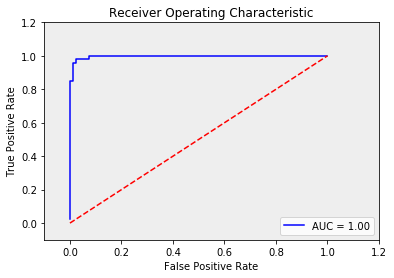

In [14]:
#Plotting ROC Curve
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, y_hat_SL)
roc_auc = auc(false_positive_rate, true_positive_rate)
fig, ax = plt.subplots(subplot_kw=dict(axisbg='#EEEEEE'))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

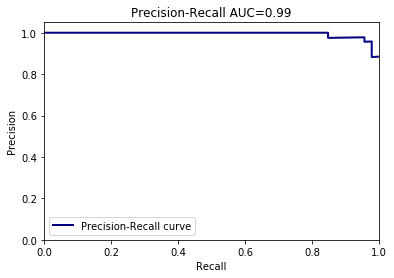

In [15]:
#Plotting precision-Recall Curve
precision, recall, threshold = precision_recall_curve(Y_test, y_hat_SL)

average_precision = average_precision_score(Y_test, y_hat_SL)
fig, ax = plt.subplots(subplot_kw=dict(axisbg='#EEEEEE'))
lw = 2

plt.clf()
plt.plot(recall, precision, lw=lw, color='navy',
         label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")
plt.show()

In [16]:
#Regression analysis, OLS for ease of interpretation
import statsmodels.formula.api as sm
sm.ols(formula = 'cancer ~ clump_thickness + size_uniformity + shape_uniformity + marginal + single_epithelial + bare_nucleoli + bland_chromatin + normal_nucleoli + mitoses', data = df).fit().summary()
#Everything but  mitoses significant predictor.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 cancer   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     382.2
Date:                Fri, 07 Jul 2017   Prob (F-statistic):          2.62e-246
Time:                        16:47:36   Log-Likelihood:                 158.51
No. Observations:                 630   AIC:                            -297.0
Df Residuals:                     620   BIC:                            -252.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept            -0.2485      0.017    -14.562      0.000        -0.282    -0.215
clump_thickness       0.0342      0.004      9.358      0.000         0.027     0.041
size_uniformity       0.0236      0.007      3.577      0.000         0.011     0.037
shape_uniformity      0.0129      0.006      2.034      0.042         0.000     0.025
marginal              0.0091      0.004      2.240      0.025         0.001     0.017
single_epithelial     0.0096      0.005      1.805      0.071        -0.001     0.020
bare_nucleoli         0.0456      0.003     13.798      0.000         0.039     0.052
bland_chromatin       0.0173      0.005      3.314      0.001         0.007     0.028
normal_nucleoli       0.0181      0.004      4.791      0.000         0.011     0.026
mitoses               0.0025      0.005      0.489      0.625        -0.007     0.012
==============================================================================
Omnibus:                       87.627   Durbin-Watson:                   1.756
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              357.434
Skew:                           0.568   Prob(JB):                     2.42e-78
Kurtosis:                       6.511   Cond. No.                         28.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
y_hat_SL.round(2)


array([-0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01,
       -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01,
       -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.  , -0.  ,
       -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
       -0.  , -0.  , -0.  , -0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
        0.02,  0.02,  0.02,  0.02,  0.02,  0.02,  0.02,  0.03,  0.03,
        0.04,  0.06,  0.07,  0.09,  0.09,  0.22,  0.23,  0.3 ,  0.35,
        0.79,  0.8 ,  0.81,  0.82,  0.84,  0.84,  0.88,  0.88,  0.9 ,
        0.91,  0.91,  0.92,  0.93,  0.93,  0.93,  0.94,  0.94,  0.94,
        0.94,  0.94,  0.95,  0.95,  0.96,  0.97,  0.97,  0.97,  0.97,
        0.97,  0.98,  0.98,  0.98,  0.98,  0.98,  0.98,  0.99,  0.99,
        1.  ,  1.01,  1.01,  1.01,  1.04,  1.05,  1.05,  1.05,  1.07])

In [54]:
for i, model in enumerate(SL.fittedmodels):
    print type(model), SL.SL.coef_[i]

<class 'sklearn.linear_model.logistic.LogisticRegression'> -0.0
<class 'sklearn.linear_model.coordinate_descent.Lasso'> 0.0749086443287
<class 'sklearn.ensemble.forest.RandomForestClassifier'> 0.00609408203096
<class 'sklearn.naive_bayes.GaussianNB'> 0.0
<class 'sklearn.naive_bayes.MultinomialNB'> -0.00773946777131
<class 'sklearn.svm.classes.SVC'> 0.197711514268
<class 'sklearn.tree.tree.DecisionTreeClassifier'> 0.0
<class 'sklearn.tree.tree.DecisionTreeRegressor'> -0.0757063472326
<class 'sklearn.linear_model.ridge.Ridge'> 0.0
<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'> 0.419455698953
<class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'> 0.0
<class 'sklearn.linear_model.base.LinearRegression'> 0.084831050089
<class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'> 0.0
<class 'sklearn.ensemble.forest.RandomForestRegressor'> 0.293871837393


AttributeError: 'SuperLearner' object has no attribute 'ols'